# Regression Modelling in Volatility of S&P 500 Index

## CMSE 202 Final Project
#### TEAM: Rainy Jain, Lorenzo Duran, Juhua Huang, Richard Arbury, Theron Mandeville, Shangrui Zhu 

### Section_003
### 5 Dec. 2022

## Methodology 
1. Introduction
    * Introduce our model and volatility.
1. Data
    * Where the data comes from
1. HAR-RV mode
    * Introduce HAR-RV model
1. Regression Analysis
    * Show regression Analysis result
1. Out of sample Prediction
1. Conclusion

### This is a project that answers these following questions:

* How can we use an Heterogeneous Autoregressive Model of Realized Volatility(HAR-RV) in order to predict the volatility of stock prices using past prices and their movement on a high frequency interval?


## I. INTRODUCTION

Volatility is a commonly used metric to assess the risk profile of a stock. It describes the degree of variation of an asset's price over time. If the price of an asset fluctuates wildly, it is said to be more volatile. The overall trend of the asset is hard to predict; this makes the asset riskier. Over the past few decades, volatility has become an essential part of understanding and predicting an assets price, and is used by most major groups of the finance industry. 


The HAR-RV Model has been the most cited volatility model, for good reason. Compared to its predecessors, such as ARIMA-ARCH models, the HAR-RV is far easier to compute and much more robust in practice. Above all, multiple published works have shown the HAR-RV model to be more effective in use when compared to other models.

For the purposes of this project, we will be using the S&P 500 to assess the extent to which HAR-RV can be used to predict the volatility, using past prices and their movement on a high frequency interval.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

## II. DATA 
   We use over 37000 price points spanning from 2019 to 2022. According to research, it was discovered that if the sample frequency is too high or too low, the data would be inaccurate, with the 5-minute sampling frequency having the best accuracy, we had to use intra-day price points being taken every 5 minutes of each day. We chose to use the S&P 500 market index as our asset because of its popularity and broad market exposure. 

**(The source of the data is Wind. Since we purchase the data for our project, thus we cannot provide the open-link of data.)** 

   The Figure 1 just tracks the price of the S&P 500 over our time interval. 
   
   The Figure 2 shows the log of returns, which gives a great visual of the volatility of the index. Periods of time with positive returns are seen above the x-axis, and negative returns are seen below.

In [2]:
data=pd.read_excel("S&P500Index_v2.xlsx")
data

,Name,Date,Day,Open,High,Low,Close
0,SPX.GI,2019-12-09 09:35:00,2019-12-09,3141.86,3143.41,3140.91,3143.41
1,SPX.GI,2019-12-09 09:40:00,2019-12-09,3143.54,3146.64,3142.95,3146.39
2,SPX.GI,2019-12-09 09:45:00,2019-12-09,3146.34,3148.04,3146.32,3147.96
3,SPX.GI,2019-12-09 09:50:00,2019-12-09,3147.92,3148.38,3147.23,3147.34
4,SPX.GI,2019-12-09 09:55:00,2019-12-09,3147.36,3148.15,3146.96,3147.80
...,...,...,...,...,...,...,...
57138,SPX.GI,2022-11-11 15:40:00,2022-11-11,3988.72,3995.15,3988.08,3994.93
57139,SPX.GI,2022-11-11 15:45:00,2022-11-11,3994.89,3997.88,3994.41,3997.82
57140,SPX.GI,2022-11-11 15:50:00,2022-11-11,3997.87,4001.28,3996.24,3999.07
57141,SPX.GI,2022-11-11 15:55:00,2022-11-11,3999.06,4000.29,3993.02,3994.29


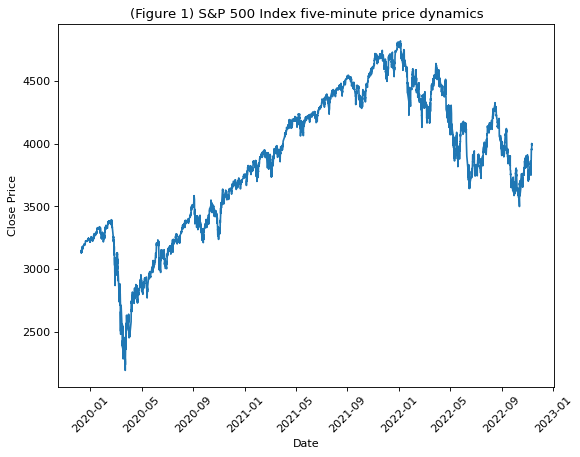

In [3]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(data['Date'], data["Close"])

plt.title('(Figure 1) S&P 500 Index five-minute price dynamics')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees

plt.show()

In [4]:
data["log_return"] = np.nan

# looping through the dataset and calculating the log return for every five minuets according to the equation from the paper
for i in range(1,len(data["Day"])):
    data.loc[i,"RVd"] = ((np.log(data.loc[i,"Close"])-np.log(data.loc[i-1,"Close"]))*100)**2
    
    
for i in range(1,len(data["Day"])):
    data.loc[i,"log_return"] = (np.log(data.loc[i,"Close"])-np.log(data.loc[i-1,"Close"]))*100

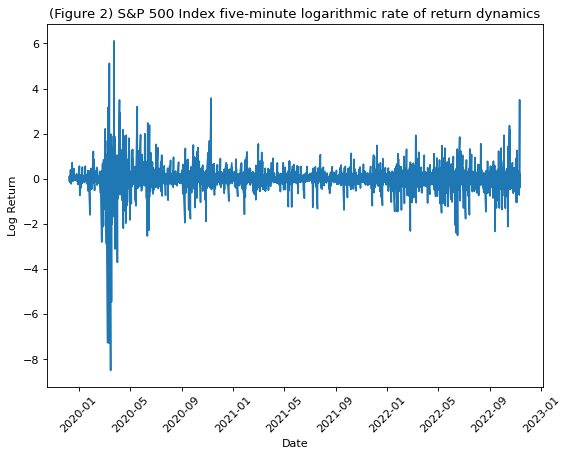

In [5]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(data['Date'], data["log_return"])

plt.title('(Figure 2) S&P 500 Index five-minute logarithmic rate of return dynamics')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

## III. HAR-RV MODEL
This section uses HAR-RV models to forecast S&P 500 Index.

According to Andersen and Bollerslev's calculation method of RV (volatility), we assume a trading day $t$, and the daily trading is divided into $M$ segments, then let $P_{(t,i)}$ represents the $i^{th}$  closing price of the trading day $t$, for $i = 1, 2, 3 ... M$. Let $r_{(t,i)}$ be the logarithmic rate of return for the $i^{th}$ period in the trading day $t$, which can be expressed as 
<br>
<br>
<center> $r_{t,i} = (lnP_{t,i} - lnP_{t,i-1}) \times 100$


The RV (volatility) of trading day $t$, $RV_t^d$, which can be expressed as
<br>
<br>
<center> $ RV_t^d = \sum_{i=1}^{M}r_{t,i}^2$


According to Corsi's research, $RV_t^w$ (The weekly RV) and $RV_t^m$ (The monthly RV) can be calculated from $RV_t^d$, as shown follow
<br> 
<br>
<center> $ RV_t^w = \frac{RV_t^d + RV_{t-1}^d + RV_{t-2}^d +...+ RV_{t-4}^d}{5}$
<br>
<br>
<center> $ RV_t^m = \frac{RV_t^d + RV_{t-1}^d + RV_{t-2}^d +...+ RV_{t-20}^d}{21}$

S&P 500 Index have about 252 trading days each year and are available to trade from Monday through Friday. As a result, the number of weekly trading days is chosen to be 5 when computing weekly RV, and the number of monthly trading days is decided to be 21 when calculating monthly RV.

The average RV from the day t to (t + H), H is the forecast horizon, is defined as
<br>
<br>
<center> $ RV_t^H = \frac{1}{H}  \sum_{i=1}^{H} RV_{t+1}^d$

The HAR-RV model:
<br>
<br>
<center> $ RV_t^H = \beta_0 + \beta_d RV_t^d + \beta_w RV_t^w + \beta_m RV_t^m $

In [6]:
# DAY
# the dataset is composed by data from every 5 minutes of shock prices

datas=data[["Day","RVd"]] # selecting the "Day" and "log_return_sqr" column
dayd=datas.groupby(by=["Day"]).sum() # using groupby to sum up the value within the same day

In [7]:
# Week (1-5)

# the return of group by will index a column automatically, I reset the index column as normal column here
dayd2=dayd.reset_index()

dayd2["RVw"]=0.0 # set the initial value as a float
dayd2.tail(10)

# looping through the "log_return_sqr" and calculating the weekly log return according to the equation from the paper
for i in range(0,len(dayd2["RVd"])-4):
    dayd2["RVw"][i]=(dayd2.loc[i:i+4,"RVd"].sum())/5
    


In [8]:
# Month
dayd2["RVm"]=0.0 # set the initial value as a float

# looping through the "log_return_sqr" and calculating the 
# monthly log return according to the equation from the paper
for i in range(0,len(dayd2["RVd"])-20):
    dayd2["RVm"][i]=dayd2.loc[i:i+20,"RVw"].sum()/21

In [9]:
# Final: droping the last 20 rows
m1=dayd2["RVm"]!=0 # making a mask that including all the values expect 0
RV=dayd2[m1] # the final dataset by saving all the row with vaild values
RV # showing the result

,Day,RVd,RVw,RVm
0,2019-12-09,0.045404,0.262899,0.237851
1,2019-12-10,0.176594,0.370473,0.234264
2,2019-12-11,0.088090,0.350744,0.225560
3,2019-12-12,0.630203,0.350151,0.217610
4,2019-12-13,0.374203,0.237072,0.210747
...,...,...,...,...
711,2022-10-10,1.491055,3.791561,2.822518
712,2022-10-11,2.392181,4.796303,2.641967
713,2022-10-12,0.746298,5.637882,2.413572
714,2022-10-13,10.838424,5.756028,2.145101


In [10]:
columns=["Day","RVd","RVw","RVm"]
RVPlus1=RV[columns]

RVPlus1=RVPlus1.iloc[1:]

# Making new column names for dataframe to add "lagged" Columns
RVPlus1.rename(columns = {'Day':'Day', 
                          'RVd':'RVd+1',
                          'RVw':'RVw+1',
                          'RVm':'RVm+1'}, inplace = True)

RVPlus1= RVPlus1.iloc[: , 1:]
RV=RV.join(RVPlus1)  # Joining lagged columns with regular columns

# Shifting to create lagged columns
RV['RVw+1'] = RV['RVw+1'].shift(-1)

RV['RVd+1'] = RV['RVd+1'].shift(-1)
RV['RVm+1'] = RV['RVm+1'].shift(-1)

RV = RV[:-1] #Removing last row to make DF columns equal length
RV.head(10)

,Day,RVd,RVw,RVm,RVd+1,RVw+1,RVm+1
0,2019-12-09,0.045404,0.262899,0.237851,0.176594,0.370473,0.234264
1,2019-12-10,0.176594,0.370473,0.234264,0.088090,0.350744,0.225560
2,2019-12-11,0.088090,0.350744,0.225560,0.630203,0.350151,0.217610
3,2019-12-12,0.630203,0.350151,0.217610,0.374203,0.237072,0.210747
4,2019-12-13,0.374203,0.237072,0.210747,0.583274,0.210662,0.209667
5,2019-12-16,0.583274,0.210662,0.209667,0.077952,0.101666,0.212439
6,2019-12-17,0.077952,0.101666,0.212439,0.085122,0.089531,0.221137
7,2019-12-18,0.085122,0.089531,0.221137,0.064809,0.087548,0.257239
8,2019-12-19,0.064809,0.087548,0.257239,0.242155,0.100733,0.294774
9,2019-12-20,0.242155,0.100733,0.294774,0.038295,0.095584,0.333346


From Figure 3, we can see that in March 2020, there is a significant structural change in S&P 500 Index volatility. Major alterations in economic conditions, such as policy moves, natural disasters, and oil crises, can cause structural change. In March 2020, the impact of a new crown pneumonia outbreak triggered a dramatic decline in gold futures prices, generating significant volatility.

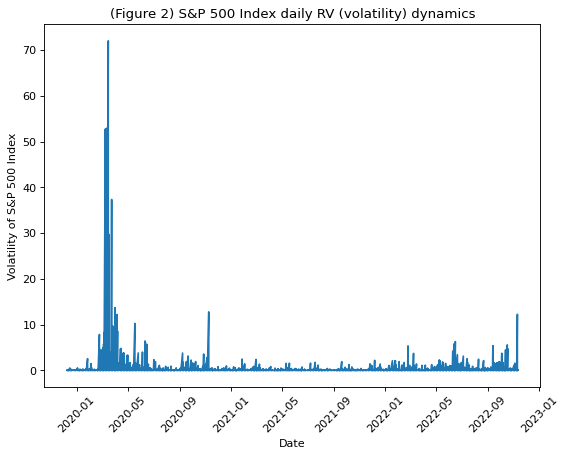

In [11]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(data['Day'], data["RVd"])

plt.title('(Figure 2) S&P 500 Index daily RV (volatility) dynamics')
plt.xlabel('Date')
plt.ylabel('Volatility of S&P 500 Index')
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

## IV. REGRESSION ANALYSIS

### A. Statistic description

According to the descriptive statistical analysis of the following main variables, the range of Daily RV is between 0.0003 - 6.850, with significant and sharp variations. Weekly RV and Monthly RV, on the other hand, have a lower fluctuation range, varying between 0.078 to 5.675 for Weekly RV and 0.2027 to 4.525 for Monthly RV. We can also observe from the standard deviation that the dispersion of Daily RV is considerably higher than that of Weekly RV and Monthly RV. The fluctuation of Daily RV is significant.

<center> Descriptive statistics of variables

| Variable | Mean | Std. dev. | Min | Max |
| --- | --- | --- | --- | --- |
| Daily RV | 2.268 | 6.850 | 0.0003 | 6.850 | 
| Weekly RV | 2.281 | 5.675 | 0.078 | 5.675 | 
| Monthly RV | 2.303 | 4.525 | 0.2027 | 4.525 | 

In [12]:
RVd = RV.loc[:,'RVd']
RVd_stat = RVd.describe()

RVw = RV.loc[:,'RVw']
RVw_stat = RVw.describe()

RVm = RV.loc[:,'RVm']
RVm_stat = RVm.describe()

print('RVd has mean:',RVd_stat['mean'],', Std. dev.:', RVd_stat['std'], 
      ', min:', RVd_stat['min'], ', max:', RVd_stat['std'])
print('RVd has mean:',RVw_stat['mean'],', Std. dev.:', RVw_stat['std'], 
      ', min:', RVw_stat['min'], ', max:', RVw_stat['std'])
print('RVd has mean:',RVm_stat['mean'],', Std. dev.:', RVm_stat['std'], 
      ', min:', RVm_stat['min'], ', max:', RVm_stat['std'])

RVd has mean: 2.2681534898477227 , Std. dev.: 6.8499881657946045 , min: 0.0003149587384302375 , max: 6.8499881657946045
RVd has mean: 2.281166940474692 , Std. dev.: 5.674676400500173 , min: 0.0779248861861382 , max: 5.674676400500173
RVd has mean: 2.3086840654207683 , Std. dev.: 4.4899421721613075 , min: 0.20966740414109258 , max: 4.4899421721613075


### B. Result analysis
Having a comparision of adjtive $R^2$ between three regressions model, we found that the model of weekly ($R^2 = 0.974$), and monthly ($R^2 = 0.996$) volatility have fit better than daily volatility model ($R^2 = 0.709$).

In every single model, all independent variables proved to be statistically significant, even at α = .01. Additionally, our R-squared values for each regression further demonstrate that the observed outcomes were well replicated by our model (e.g., roughly 99.6% of variation in the monthly volatility of the S&P 500 can be explained by the regression we constructed). 

This all shows that the HAR-RV model can in fact be used to predict the volatility of the S&P 500 across the selected time period, using the past prices of the index and their movement on a five-minute interval.

In [13]:
# Define a function for train OLS model 
def mul_regress(X,y):
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    return results

In [14]:
X = RV[['RVd','RVw','RVm']] # Independent variable 
X = sm.add_constant(X)

In [15]:
y_day = RV['RVd+1'] # Dependent variable

# Train OLS model with RVd+1 as dependent variable
RVd_regress = mul_regress(X,y_day) 
RVd_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  RVd+1   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     584.1
Date:                Mon, 05 Dec 2022   Prob (F-statistic):          2.59e-191
Time:                        21:37:15   Log-Likelihood:                -1945.6
No. Observations:                 715   AIC:                             3899.
Df Residuals:                     711   BIC:                             3918.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2034      0.156      1.303      0.193      -0.103       0.510
RVd           -0.2837      0.036     -7.986      0.000      -0.354      -0.214
RVw            1.3570      0.049     27.515      0.000       1.260       1.454
RVm           -0.1657      0.040     -4.190      0.000      -0.243      -0.088
==============================================================================
Omnibus:                      345.211   Durbin-Watson:                   2.249
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           444741.243
Skew:                           0.471   Prob(JB):                         0.00
Kurtosis:                     125.178   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
y_week = RV['RVw+1'] # Dependent variable

# Train OLS model with RVw+1 as dependent variable
RVw_regress = mul_regress(X,y_week)
RVw_regress.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  RVw+1   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     8914.
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:37:15   Log-Likelihood:                -949.12
No. Observations:                 715   AIC:                             1906.
Df Residuals:                     711   BIC:                             1925.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0379      0.039     -0.979      0.328      -0.114       0.038
RVd           -0.2257      0.009    -25.602      0.000      -0.243      -0.208
RVw            1.1475      0.012     93.761      0.000       1.123       1.172
RVm            0.0946      0.010      9.643      0.000       0.075       0.114
==============================================================================
Omnibus:                     1040.208   Durbin-Watson:                   2.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           377159.632
Skew:                           7.855   Prob(JB):                         0.00
Kurtosis:                     114.414   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
y_month = RV['RVm+1'] # Dependent variable

# Train OLS model with RVm+1 as dependent variable
RVm_regress = mul_regress(X,y_month)
RVm_regress.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  RVm+1   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.121e+05
Date:                Mon, 05 Dec 2022   Prob (F-statistic):               0.00
Time:                        21:37:15   Log-Likelihood:                 114.88
No. Observations:                 715   AIC:                            -221.8
Df Residuals:                     711   BIC:                            -203.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0419      0.009      4.786      0.000       0.025       0.059
RVd            0.0056      0.002      2.830      0.005       0.002       0.010
RVw           -0.0729      0.003    -26.378      0.000      -0.078      -0.067
RVm            1.0493      0.002    473.679      0.000       1.045       1.054
==============================================================================
Omnibus:                      855.138   Durbin-Watson:                   0.135
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            96500.331
Skew:                           5.820   Prob(JB):                         0.00
Kurtosis:                      58.711   Cond. No.                         11.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## V. OUT OF SAMPLE PREDICTION



In this section, we use out-of-sample prediction to determine if a proposed leading indicator is potentially useful for forecasting a target variable. 

The steps for conducting an out-of-sample forecasting experiment are as follows:

1. Divide the data into two parts: 
    * Set the in-sample data set (roughly 50% of the data)
    *  Set the out-of-sample data set (the remaining 50% of the entire data set).
<br>
<br>
2. We choose H = 1 as appropriate forecast horizon and loss function for the forecasting experiment. 
    - The forecast horizon is the number of steps ahead that one is most interested in forecasting the target variable. 
    - For example, if we interested in obtaining accurate forecasts of volatility one day ahead and the appropriate forecast horizon would be H = 1. 
<br>
<br>
3. Use in-sample data set to train an OLS model, then predict one day ahead volatility by using out-of-sample data set in OLS model.

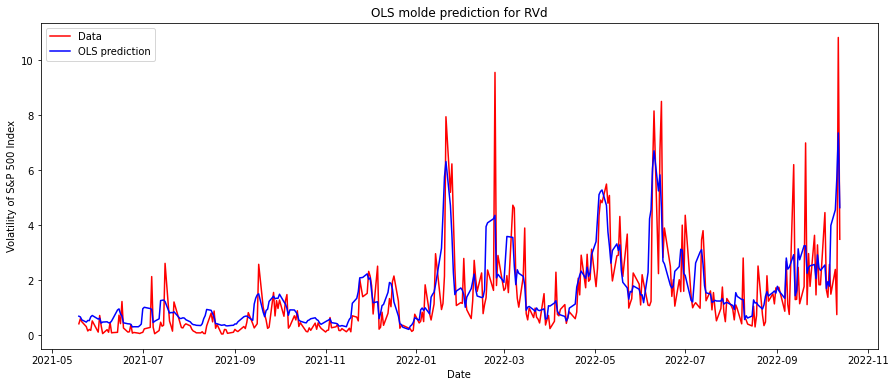

In [18]:

RV_0_360 = RV.iloc[:361,:] # in-sample data set
RV_361_715 = RV.iloc[361:,:] # out-of-sample data set


# Train OLS model with in-sample data set
X = RV_0_360[['RVd','RVw','RVm']] # Independent variable 
X = sm.add_constant(X)
y_day = RV_0_360['RVd+1']  # Dependent variable 
Rvd_half_regress = mul_regress(X,y_day) 

Xnew = RV_361_715[['RVd','RVw','RVm']] 
Xnew = sm.add_constant(Xnew)

# Predict RVd by out-of-sample data set
ynewpred_d = Rvd_half_regress.predict(Xnew) 
RV_361_715['prediect_RVd'] = ynewpred_d

# Plot the graph
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(RV_361_715['Day'], RV_361_715['RVd+1'], "r-", label="Data")
ax.plot(RV_361_715['Day'], RV_361_715['prediect_RVd'], "b-", label="OLS prediction")
plt.title('OLS molde prediction for RVd')
plt.xlabel('Date')
plt.ylabel('Volatility of S&P 500 Index')
ax.legend(loc="best")
plt.show()

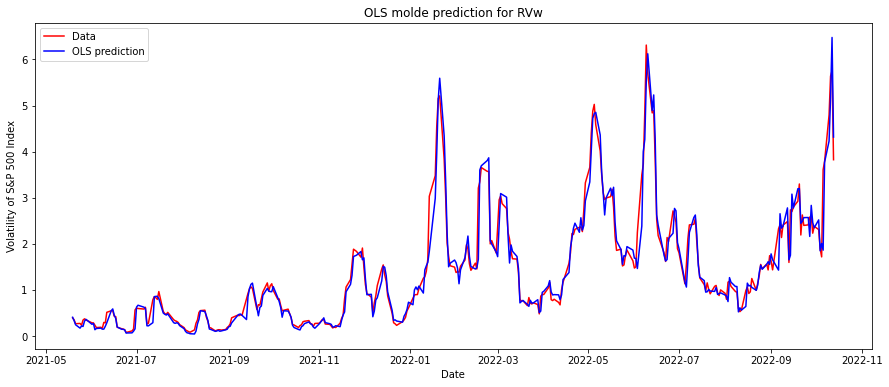

In [19]:
# Train OLS model with in-sample data set
y_week = RV_0_360['RVw+1'] # Dependent variable
Rvw_half_regress = mul_regress(X,y_week)

# Predict RVw by out-of-sample data set
ynewpred_w = Rvw_half_regress.predict(Xnew) 
RV_361_715['prediect_RVw'] = ynewpred_w

# Plot the graph
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(RV_361_715['Day'], RV_361_715['RVw+1'], "r-", label="Data")
ax.plot(RV_361_715['Day'], RV_361_715['prediect_RVw'], "b-", label="OLS prediction")
plt.title('OLS molde prediction for RVw')
plt.xlabel('Date')
plt.ylabel('Volatility of S&P 500 Index')
ax.legend(loc="best")
plt.show()

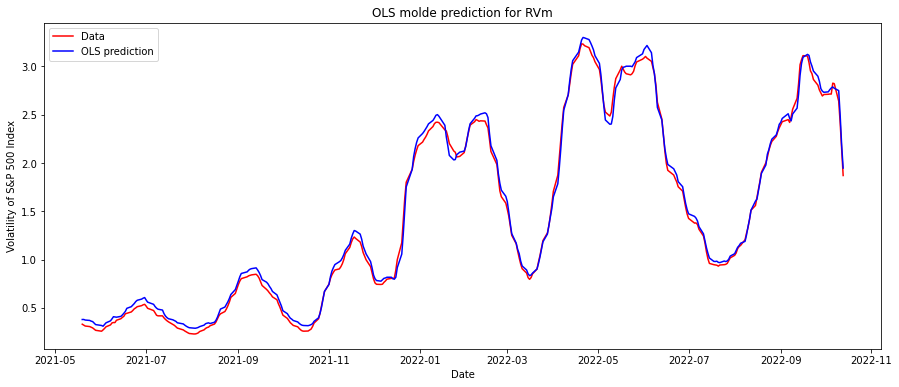

In [20]:
# Train OLS model with in-sample data set
y_month = RV_0_360['RVm+1'] # Dependent variable
Rvd_half_regress = mul_regress(X,y_month)

# Predict RVm by out-of-sample data set
ynewpred_m = Rvd_half_regress.predict(Xnew) 
RV_361_715['prediect_RVm'] = ynewpred_m

# Plot the graph
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(RV_361_715['Day'], RV_361_715['RVm+1'], "r-", label="Data")
ax.plot(RV_361_715['Day'], RV_361_715['prediect_RVm'], "b-", label="OLS prediction")
plt.title('OLS molde prediction for RVm')
plt.xlabel('Date')
plt.ylabel('Volatility of S&P 500 Index')
ax.legend(loc="best")

## VI . CONCLUSION
Volatility forecasting is vital today to managing and accessing assets. As seen in literature and in our own modeling, the HAR-RV model produced a very accurate model for forecasting volatility in the S&P 500. The monthly time series had the best results, with the predicted data fitting the test data extremely well. Every model had an R2 above 75%, with the monthly and weekly each showing over 95% as well, The model not only performed well, but hopefully demonstrated a relatively simple way to measure volatility using OLS regression.


## REFERENCES

* Corsi, F. (2009). A Simple Approximate Long-Memory Model of Realized Volatility. Journal of Financial Econometrics, 7(2), 174–196.   https://doi.org/10.1093/jjfinec/ nbp001

* Andersen, T. G., & Bollerslev, T. (1998). Answering the skeptics: Yes, standard volatility models do provide accurate forecasts. International Economic Review, 39(4), 885–905. 

* Li, W., Cheng, Y., & Fang, Q. (2020). Forecast on silver futures linked with structural breaks and day-of-the-week effect. The North American Journal of Economics and Finance, 53, 101192. https://doi.org/10.1016/j.najef.2020.101192

